In [1]:
!pip install 'fhnw-nlp-utils>=0.1.3' pyarrow fastparquet

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
file = "data/german_news_articles_original_train_and_test_tokenized.parq"
data_all = load_dataframe(file)

In [3]:
data_all.sample(10)

,text_original,label,split,text_clean,token_clean,token_stem,token_clean_stopwords
863,Neue Aufnahmen der Nasa-Sonde New Horizons ent...,Wissenschaft,test,Neue Aufnahmen der Nasa Sonde New Horizons ent...,"[neue, aufnahmen, nasa, sonde, new, horizons, ...","[neu, aufnahm, nasa, sond, new, horizon, enthu...","[neue, aufnahmen, nasa, sonde, new, horizons, ..."
1638,"""Star Wars"", ""Assassin’s Creed"", ""Doctor Who"" ...",Etat,train,Star Wars Assassin Creed Doctor Who und jede ...,"[star, wars, assassin, creed, doctor, who, men...","[star, war, assassin, creed, doctor, who, meng...","[star, wars, assassin, creed, doctor, who, men..."
4183,Sollte der Oberste Gerichtshof Obamacare für v...,International,train,Sollte der Oberste Gerichtshof Obamacare für v...,"[oberste, gerichtshof, obamacare, verfassungsw...","[oberst, gerichtshof, obamacar, verfassungswid...","[oberste, gerichtshof, obamacare, verfassungsw..."
7442,Spanier egalisiert 0:2-Rückstand des Titelvert...,Sport,train,Spanier egalisiert Rückstand des Titelverteidi...,"[spanier, egalisiert, rückstand, titelverteidi...","[spani, egalisiert, ruckstand, titelverteid, r...","[spanier, egalisiert, rückstand, titelverteidi..."
8528,In Österreich sorgt nun ein Plan für Aufregung...,Wirtschaft,train,In Österreich sorgt nun ein Plan für Aufregung...,"[österreich, sorgt, plan, aufregung, beimischu...","[osterreich, sorgt, plan, aufreg, beimisch, re...","[österreich, sorgt, plan, aufregung, beimischu..."
1258,"""Beleidigung der patriotischen Gefühle"" – Demo...",Etat,train,Beleidigung der patriotischen Gefühle Demonst...,"[beleidigung, patriotischen, gefühle, demonstr...","[beleid, patriot, gefuhl, demonstration, sendu...","[beleidigung, patriotischen, gefühle, demonstr..."
7846,Erste Ergebnisse der Magnetospheric Multiscale...,Wissenschaft,train,Erste Ergebnisse der Magnetospheric Multiscale...,"[erste, ergebnisse, magnetospheric, multiscale...","[erst, ergebnis, magnetospheric, multiscal, mi...","[erste, ergebnisse, magnetospheric, multiscale..."
9193,Identität des Toten noch ungeklärt – Vier Poli...,International,train,Identität des Toten noch ungeklärt Vier Polizi...,"[identität, toten, ungeklärt, vier, polizisten...","[identitat, tot, ungeklart, vier, polizist, wu...","[identität, toten, ungeklärt, vier, polizisten..."
588,Abd Rabbo Mansour Hadi will in Aden eine Milit...,International,test,Abd Rabbo Mansour Hadi will in Aden eine Milit...,"[abd, rabbo, mansour, hadi, aden, militäroffen...","[abd, rabbo, mansour, hadi, aden, militaroffen...","[abd, rabbo, mansour, hadi, aden, militäroffen..."
1098,Testberichte der Fachmagazine falle überwiegen...,Web,train,Testberichte der Fachmagazine falle überwiegen...,"[testberichte, fachmagazine, falle, überwiegen...","[testbericht, fachmagazin, fall, uberwieg, pos...","[testberichte, fachmagazine, falle, überwiegen..."


In [27]:
data_train = data_all.loc[(data_all["split"] == "train")]
data_test = data_all.loc[(data_all["split"] == "test")]

print(data_all.shape, data_train.shape, data_test.shape)


X_train, y_train = data_train["token_stem"], data_train["label"]
X_test, y_test = data_test["token_stem"], data_test["label"]

(10273, 7) (9245, 7) (1028, 7)


In [21]:
y_train = y_train.reindex(np.random.permutation(y_train.index))
y_test = y_test.reindex(np.random.permutation(y_test.index))

Etat             0.065025
Inland           0.098803
International    0.147085
Kultur           0.052468
Panorama         0.163341
Sport            0.116908
Web              0.163243
Wirtschaft       0.137350
Wissenschaft     0.055777
Name: label, dtype: float64


<AxesSubplot:>

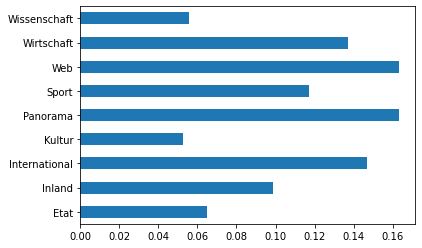

In [28]:
val_counts = data_all["label"].value_counts().sort_index()


val_counts = val_counts / np.sum(val_counts)
print(val_counts)
val_counts.plot(kind='barh')

In [74]:
%%time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

pipe = Pipeline([
         ("vec", CountVectorizer(tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", SGDClassifier())
        ])
pipe.fit(X_train, y_train)

CPU times: user 2.48 s, sys: 4.85 s, total: 7.33 s
Wall time: 1.17 s


Pipeline(steps=[('vec',
                 CountVectorizer(preprocessor=<function <lambda> at 0x7fadd271de18>,
                                 tokenizer=<function <lambda> at 0x7fadd40a3c80>)),
                ('tfidf', TfidfTransformer()), ('clf', SGDClassifier())])

In [111]:
print(pipe['vec'].transform(['merkel', 'gold']).shape)

len(pipe['tfidf'].idf_)

(2, 125929)


125929

In [75]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [12]:
y_test_pred

array(['Wirtschaft', 'Sport', 'Web', ..., 'Sport', 'Sport', 'Web'],
      dtype=object)

In [54]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
               precision    recall  f1-score   support

         Etat       0.99      0.99      0.99       601
       Inland       0.98      0.98      0.98       913
International       0.99      0.98      0.99      1360
       Kultur       1.00      1.00      1.00       485
     Panorama       0.98      0.99      0.99      1510
        Sport       1.00      1.00      1.00      1081
          Web       0.99      0.99      0.99      1509
   Wirtschaft       0.98      0.99      0.99      1270
 Wissenschaft       0.99      1.00      1.00       516

     accuracy                           0.99      9245
    macro avg       0.99      0.99      0.99      9245
 weighted avg       0.99      0.99      0.99      9245

Test:
               precision    recall  f1-score   support

         Etat       0.90      0.84      0.87        67
       Inland       0.87      0.82      0.84       102
International       0.87      0.83      0.85       151
       Kultur       0.87      0.85      0.86    

Set Population: 1028
Accuracy: 0.8794


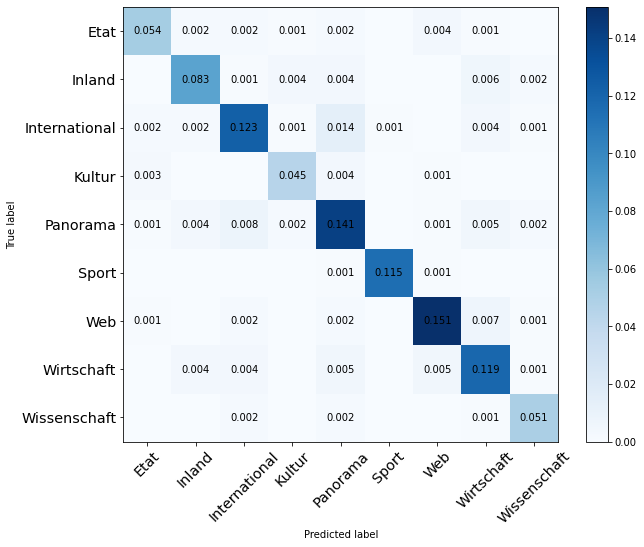

In [76]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

#plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [56]:
data_test.iloc[42], X_test.iloc[42]

(text_original            Mehr als halbe Million Euro Bußgeld wegen Wett...
 label                                                           Wirtschaft
 split                                                                 test
 text_clean               Mehr als halbe Million Euro Bußgeld wegen Wett...
 token_clean              [mehr, halbe, million, bußgeld, wegen, wettbew...
 token_stem               [mehr, halb, million, bussgeld, weg, wettbewer...
 token_clean_stopwords    [mehr, halbe, million, bußgeld, wegen, wettbew...
 Name: 42, dtype: object,
 array(['mehr', 'halb', 'million', 'bussgeld', 'weg', 'wettbewerbsvergeh',
        'marz', 'juli', 'traun', 'kartellgericht', 'pfeiff', 'handelsgmbh',
        'der', 'tocht', 'zielpunkt', 'gmbh', 'geldbuss', 'hoh', 'verhangt',
        'unternehm', 'verschied', 'lieferant', 'preis', 'abgesproch',
        'teilt', 'heut', 'freitag', 'bundeswettbewerbsbehord', 'bwb',
        'homepag', 'entscheid', 'kartellgericht', 'juli', 'rechtskraft',
  

In [77]:
pipe.predict([['champion', 'leaque']])

array(['Sport'], dtype='<U13')

In [104]:
pipe.predict([['merkel', 'silber']])

array(['International'], dtype='<U13')

In [100]:
row = 167
print(data_test.iloc[row, [0,1]])
pipe.predict(X_test.iloc[row].reshape(1,-1))

text_original    Großeinsatz von Armee und Polizei in südöstlic...
label                                                International
Name: 167, dtype: object


array(['International'], dtype='<U13')